In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import os 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from matplotlib import patheffects
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
import matplotlib.image as mpimg

In [2]:
yesterday_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
yesterday_date

'2024-03-21'

# CHARGEMENT DES DONNEES

# 

In [3]:
dialect = 'mysql+pymysql'
user = 'root'
password = os.getenv('mdp_mySQL')
host = 'localhost'
port = 3306
database_idf = 'SNCF_TGV_TER'

engine_url = f"{dialect}://{user}:{password}@{host}:{port}/{database_idf}"
engine = create_engine(engine_url)

In [4]:
query_disruption = f"""
SELECT * FROM disruptions_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_disruption = pd.read_sql_query(query_disruption, engine)
df_disruption

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date
0,c02e5354-b0b2-4fde-b79a-d9e760e491c8,SNCF:2024-03-21:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 10:46:00,2024-03-21 12:58:00,5.0,5.0,Dérangement d'un équipement technique ou infor...,2024-03-21
1,c02e5354-b0b2-4fde-b79a-d9e760e491c8,SNCF:2024-03-21:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-21 10:46:00,2024-03-21 12:58:00,0.0,0.0,Dérangement d'un équipement technique ou infor...,2024-03-21
2,7e9369fd-e9d6-4077-8477-ebf61b53fe99,SNCF:2024-03-21:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 11:04:00,2024-03-21 16:14:00,0.0,0.0,Défaillance de matériel,2024-03-21
3,7e9369fd-e9d6-4077-8477-ebf61b53fe99,SNCF:2024-03-21:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-21 11:04:00,2024-03-21 16:14:00,180.0,180.0,Défaillance de matériel,2024-03-21
4,ebac9f44-ea45-4241-90cb-58ad94023506,SNCF:2024-03-21:12259:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 12:04:00,2024-03-21 14:19:00,0.0,0.0,Incident de circulation,2024-03-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87713040:LongDistanceTrain,Dijon,5.027260,47.3234,2024-03-21 06:31:00,2024-03-21 14:30:00,15.0,15.0,Panne d'un passage à niveau,2024-03-21
5723,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-21 06:31:00,2024-03-21 14:30:00,15.0,10.0,Panne d'un passage à niveau,2024-03-21
5724,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87763029:LongDistanceTrain,Valence TGV Rhône-Alpes Sud,4.978650,44.9919,2024-03-21 06:31:00,2024-03-21 14:30:00,5.0,5.0,Panne d'un passage à niveau,2024-03-21
5725,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87773002:LongDistanceTrain,Montpellier Saint-Roch,3.880670,43.6047,2024-03-21 06:31:00,2024-03-21 14:30:00,0.0,0.0,Panne d'un passage à niveau,2024-03-21


In [5]:
query_vehicle = f"""
SELECT * FROM vehicle_journeys_tgv_ter
WHERE data_date = '{yesterday_date}'
"""

df_vehicle = pd.read_sql_query(query_vehicle, engine)
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,vehicle_journey:SNCF:2024-03-21:12244:1187:Lon...,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-21
1,vehicle_journey:SNCF:2024-03-21:12251:1187:Lon...,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-21
2,vehicle_journey:SNCF:2024-03-21:12254:1187:Lon...,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,c02e5354-b0b2-4fde-b79a-d9e760e491c8,2024-03-21
3,vehicle_journey:SNCF:2024-03-21:12255:1187:Lon...,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,7e9369fd-e9d6-4077-8477-ebf61b53fe99,2024-03-21
4,vehicle_journey:SNCF:2024-03-21:12258:1187:Lon...,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-21
...,...,...,...,...,...,...,...
8919,vehicle_journey:SNCF:2024-03-21:9890:1187:Long...,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-21
8920,vehicle_journey:SNCF:2024-03-21:9894:1187:Long...,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-21
8921,vehicle_journey:SNCF:2024-03-21:9896:1187:Long...,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-21
8922,vehicle_journey:SNCF:2024-03-21:9898:1187:Long...,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,2024-03-21


In [6]:
df_lines = pd.read_sql_table('pt_lines_tgv_ter', engine)
df_lines

,route_id,route_name,train_type,network_name,opening_time,closing_time
0,route:SNCF:0018-80100537-87271007,Dortmund Hbf - Paris Nord,Train grande vitesse,Eurostar,05:18:00,12:21:00
1,route:SNCF:0018-80101840-87271007,Essen Hbf - Paris Nord,Train grande vitesse,Eurostar,07:35:00,22:14:00
2,route:SNCF:0018-80154583-87271007,Köln - Hauptbahnhof - Paris Nord,Train grande vitesse,Eurostar,05:21:00,23:14:00
3,route:SNCF:0018-84000588-87111849,Amsterdam Centraal - Marne-la-Vallée - Chessy,Train grande vitesse,Eurostar,06:47:00,11:05:00
4,route:SNCF:0018-84000588-87271007,Amsterdam Centraal - Paris Nord,Train grande vitesse,Eurostar,06:11:00,23:43:00
...,...,...,...,...,...,...
363,route:stop_area:SNCF:87113001_stop_area:SNCF:8...,Paris Est - Strasbourg,Train grande vitesse,additional service,None,None
364,route:stop_area:SNCF:87394007_stop_area:SNCF:8...,Chartres - Versailles Chantiers,Train grande vitesse,additional service,None,None
365,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Paris Saint-Lazare,Train grande vitesse,additional service,None,None
366,route:stop_area:SNCF:87411017_stop_area:SNCF:8...,Rouen Rive Droite - Le Havre,Train grande vitesse,additional service,None,None


# 

# 

# ANALYSE DES DONNEES

# 

## NOMBRE DE PERTURBATION

In [7]:
nb_disruption = len(df_disruption['id_disruption'].unique())
print("nombre de perturbation : " + str(nb_disruption))

nombre de perturbation : 642


## POURCENTAGE TRAJET IMPACTE

In [8]:
nb_vehicle_journeys = len(df_vehicle)
print("nombre de trajet : " + str(nb_vehicle_journeys))

impacted_journeys = df_vehicle['id_disruption'].notnull().sum()
print("nombre de trajet impacté : " + str(impacted_journeys))

per_impacted = impacted_journeys/nb_vehicle_journeys*100
print("pourcentage de trajet impacté : " + str(round(per_impacted,2)) + "%")

nombre de trajet : 8924
nombre de trajet impacté : 1146
pourcentage de trajet impacté : 12.84%


## Temps total de perturbation


In [9]:
df_disruption['duration'] = df_disruption['disruption_end'] - df_disruption['disruption_start']
df_disruption_unique = df_disruption[~df_disruption.duplicated(subset=['id_disruption'], keep='first')]
total_disruption_duration =  df_disruption_unique['duration'].sum()
print("temps cumulé de perturbation : " +  str(total_disruption_duration))

temps cumulé de perturbation : 48 days 22:31:30


## Information sur la première perturbation de la journée

In [10]:
df_vehicle['vehicle_id'] = df_vehicle['vehicle_id'].apply(lambda x: ':'.join(x.split(':')[1:]))
df_vehicle

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date
0,SNCF:2024-03-21:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-21
1,SNCF:2024-03-21:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-21
2,SNCF:2024-03-21:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,c02e5354-b0b2-4fde-b79a-d9e760e491c8,2024-03-21
3,SNCF:2024-03-21:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,7e9369fd-e9d6-4077-8477-ebf61b53fe99,2024-03-21
4,SNCF:2024-03-21:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-21
...,...,...,...,...,...,...,...
8919,SNCF:2024-03-21:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-21
8920,SNCF:2024-03-21:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-21
8921,SNCF:2024-03-21:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-21
8922,SNCF:2024-03-21:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,2024-03-21


In [11]:
df_merge_inter = pd.merge(df_disruption, df_vehicle[['route_id', 'vehicle_id']], on='vehicle_id', how='left')
df_disruption_merge = pd.merge(df_merge_inter, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_disruption_merge

,id_disruption,vehicle_id,train_type,id_stop,name_stop,lon,lat,disruption_start,disruption_end,arrival_delay,departure_delay,cause_delay,data_date,duration,route_id,route_name,network_name
0,c02e5354-b0b2-4fde-b79a-d9e760e491c8,SNCF:2024-03-21:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 10:46:00,2024-03-21 12:58:00,5.0,5.0,Dérangement d'un équipement technique ou infor...,2024-03-21,0 days 02:12:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,c02e5354-b0b2-4fde-b79a-d9e760e491c8,SNCF:2024-03-21:12254:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-21 10:46:00,2024-03-21 12:58:00,0.0,0.0,Dérangement d'un équipement technique ou infor...,2024-03-21,0 days 02:12:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,7e9369fd-e9d6-4077-8477-ebf61b53fe99,SNCF:2024-03-21:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 11:04:00,2024-03-21 16:14:00,0.0,0.0,Défaillance de matériel,2024-03-21,0 days 05:10:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,7e9369fd-e9d6-4077-8477-ebf61b53fe99,SNCF:2024-03-21:12255:1187:LongDistanceTrain,TGV,stop_point:SNCF:87581009:LongDistanceTrain,Bordeaux Saint-Jean,-0.556697,44.8259,2024-03-21 11:04:00,2024-03-21 16:14:00,180.0,180.0,Défaillance de matériel,2024-03-21,0 days 05:10:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,ebac9f44-ea45-4241-90cb-58ad94023506,SNCF:2024-03-21:12259:1187:LongDistanceTrain,TGV,stop_point:SNCF:87391003:LongDistanceTrain,Paris - Montparnasse - Hall 1 & 2,2.320510,48.8412,2024-03-21 12:04:00,2024-03-21 14:19:00,0.0,0.0,Incident de circulation,2024-03-21,0 days 02:15:00,route:SNCF:CSR:421400,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5722,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87713040:LongDistanceTrain,Dijon,5.027260,47.3234,2024-03-21 06:31:00,2024-03-21 14:30:00,15.0,15.0,Panne d'un passage à niveau,2024-03-21,0 days 07:59:00,route:SNCF:CSR:071200,Montpellier Saint-Roch - Strasbourg,TGV INOUI
5723,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87723197:LongDistanceTrain,Lyon Part Dieu,4.859410,45.7606,2024-03-21 06:31:00,2024-03-21 14:30:00,15.0,10.0,Panne d'un passage à niveau,2024-03-21,0 days 07:59:00,route:SNCF:CSR:071200,Montpellier Saint-Roch - Strasbourg,TGV INOUI
5724,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87763029:LongDistanceTrain,Valence TGV Rhône-Alpes Sud,4.978650,44.9919,2024-03-21 06:31:00,2024-03-21 14:30:00,5.0,5.0,Panne d'un passage à niveau,2024-03-21,0 days 07:59:00,route:SNCF:CSR:071200,Montpellier Saint-Roch - Strasbourg,TGV INOUI
5725,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,SNCF:2024-03-21:9898:1187:LongDistanceTrain,TGV,stop_point:SNCF:87773002:LongDistanceTrain,Montpellier Saint-Roch,3.880670,43.6047,2024-03-21 06:31:00,2024-03-21 14:30:00,0.0,0.0,Panne d'un passage à niveau,2024-03-21,0 days 07:59:00,route:SNCF:CSR:071200,Montpellier Saint-Roch - Strasbourg,TGV INOUI


In [12]:
index_first_disruption = df_disruption_merge.loc[df_disruption_merge['disruption_start'] >= yesterday_date]['disruption_start'].idxmin()

hour_first_disruption = df_disruption_merge['disruption_start'][index_first_disruption]
print("horraire de la première perturbation de la journée : " + str(hour_first_disruption))

cause_first_disruption = df_disruption_merge['cause_delay'][index_first_disruption]
print("cause de la perturbation : " + str(cause_first_disruption))

route_first_disruption = df_disruption_merge['route_name'][index_first_disruption]
print("nom de la ligne impactée : " + str(route_first_disruption))

network_first_disruption = df_disruption_merge['network_name'][index_first_disruption]
print("réseau : " + str(network_first_disruption))

horraire de la première perturbation de la journée : 2024-03-21 04:40:00
cause de la perturbation : Conditions de départ non réunies
nom de la ligne impactée : Marseille - Miramas - Nimes - Montpellier
réseau : TER


## Réseaux les plus perturbés (Graphique N°1)


In [13]:
df_vehicle_merge = pd.merge(df_vehicle, df_lines[['route_id', 'route_name', 'network_name']], on='route_id', how='left')
df_vehicle_merge

,vehicle_id,route_id,time_begin,time_end,train_type,id_disruption,data_date,route_name,network_name
0,SNCF:2024-03-21:12244:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 18:46:00,0 days 20:59:00,Train grande vitesse,None,2024-03-21,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
1,SNCF:2024-03-21:12251:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 07:04:00,0 days 09:14:00,Train grande vitesse,None,2024-03-21,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
2,SNCF:2024-03-21:12254:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 10:46:00,0 days 12:53:00,Train grande vitesse,c02e5354-b0b2-4fde-b79a-d9e760e491c8,2024-03-21,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
3,SNCF:2024-03-21:12255:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 11:04:00,0 days 13:14:00,Train grande vitesse,7e9369fd-e9d6-4077-8477-ebf61b53fe99,2024-03-21,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
4,SNCF:2024-03-21:12258:1187:LongDistanceTrain,route:SNCF:CSR:421400,0 days 13:46:00,0 days 15:53:00,Train grande vitesse,None,2024-03-21,Paris - Montparnasse - Hall 1 & 2 - Bordeaux S...,TGV INOUI
...,...,...,...,...,...,...,...,...,...
8919,SNCF:2024-03-21:9890:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 05:59:00,0 days 09:43:00,Train grande vitesse,None,2024-03-21,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8920,SNCF:2024-03-21:9894:1187:LongDistanceTrain,route:SNCF:CSR:005400,0 days 17:01:00,0 days 21:01:00,Train grande vitesse,None,2024-03-21,Strasbourg - Bruxelles-Midi / Brussel-Zuid,TGV INOUI
8921,SNCF:2024-03-21:9896:1187:LongDistanceTrain,route:SNCF:CSR:071100,0 days 15:56:00,0 days 23:49:00,Train grande vitesse,None,2024-03-21,Nancy - Nice,TGV INOUI
8922,SNCF:2024-03-21:9898:1187:LongDistanceTrain,route:SNCF:CSR:071200,0 days 06:31:00,0 days 14:15:00,Train grande vitesse,9b2c2a8a-ef87-41a9-baed-cf882b9fc4c9,2024-03-21,Montpellier Saint-Roch - Strasbourg,TGV INOUI


In [14]:
vehicle_by_network = df_vehicle_merge.groupby('network_name')['vehicle_id'].count()

vehicle_by_network = vehicle_by_network.sort_index()

vehicle_by_network

network_name
DB SNCF                    60
Eurostar                  104
Intercités                 50
Intercités de nuit          4
LEX                       111
OUIGO                      54
OUIGO Train Classique       6
TER                      3057
TER HDF                   367
TER NA                    233
TGV INOUI                 558
TGV Lyria                  34
Name: vehicle_id, dtype: int64

In [15]:
disrupted_vehicle_by_network = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('network_name')['vehicle_id'].count()

for name in vehicle_by_network.index:
    if not(name in disrupted_vehicle_by_network.index):
        disrupted_vehicle_by_network[name] = 0
        
disrupted_vehicle_by_network = disrupted_vehicle_by_network.sort_index()
disrupted_vehicle_by_network

network_name
DB SNCF                    7
Eurostar                   1
Intercités                11
Intercités de nuit         1
LEX                        4
OUIGO                     11
OUIGO Train Classique      0
TER                      325
TER HDF                  111
TER NA                    24
TGV INOUI                 95
TGV Lyria                  7
Name: vehicle_id, dtype: int64

In [16]:
per_disrupted_vehicle_by_network = (disrupted_vehicle_by_network/vehicle_by_network *100).where(disrupted_vehicle_by_network >= 1, 0).sort_values(ascending=True)

per_disrupted_vehicle_by_network

network_name
OUIGO Train Classique     0.000000
Eurostar                  0.961538
LEX                       3.603604
TER NA                   10.300429
TER                      10.631338
DB SNCF                  11.666667
TGV INOUI                17.025090
OUIGO                    20.370370
TGV Lyria                20.588235
Intercités               22.000000
Intercités de nuit       25.000000
TER HDF                  30.245232
Name: vehicle_id, dtype: float64

In [17]:
df_disruption_merge['time_disruption'] = df_disruption_merge['disruption_end'] - df_disruption_merge['disruption_start']

In [18]:
#Transformer en minutes éventuellement
total_delay_by_network = df_disruption_merge.drop_duplicates(['id_disruption', 'vehicle_id']).groupby('network_name')['arrival_delay'].sum()
avg_delay_by_network = total_delay_by_network/vehicle_by_network

for i in range(len(disrupted_vehicle_by_network)):
    if not(disrupted_vehicle_by_network.index[i] in total_delay_by_network.index) : 
        avg_delay_by_network[i] = 0
        
for i in range(len(avg_delay_by_network)):
    if avg_delay_by_network[i] != 0:
        avg_delay_by_network[i] = str(int(avg_delay_by_network[i]*60)) + " secondes" 
    else : 
        avg_delay_by_network[i] = "0 seconde"
    
print("temps moyen de retard par train en seconde pour chaque réseau : \n\n" + str(avg_delay_by_network))

temps moyen de retard par train en seconde pour chaque réseau : 

network_name
DB SNCF                   5 secondes
Eurostar                   0 seconde
Intercités               72 secondes
Intercités de nuit       75 secondes
LEX                       8 secondes
OUIGO                    38 secondes
OUIGO Train Classique      0 seconde
TER                      31 secondes
TER HDF                  90 secondes
TER NA                   37 secondes
TGV INOUI                31 secondes
TGV Lyria                 8 secondes
dtype: object


In [19]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions
info = [vehicle_by_network,disrupted_vehicle_by_network,avg_delay_by_network,vehicle_by_network]
info_name = ["Nombre de trajet", "Nombre de trajet \n perturbé", "Retard moyen \n par train", ""]

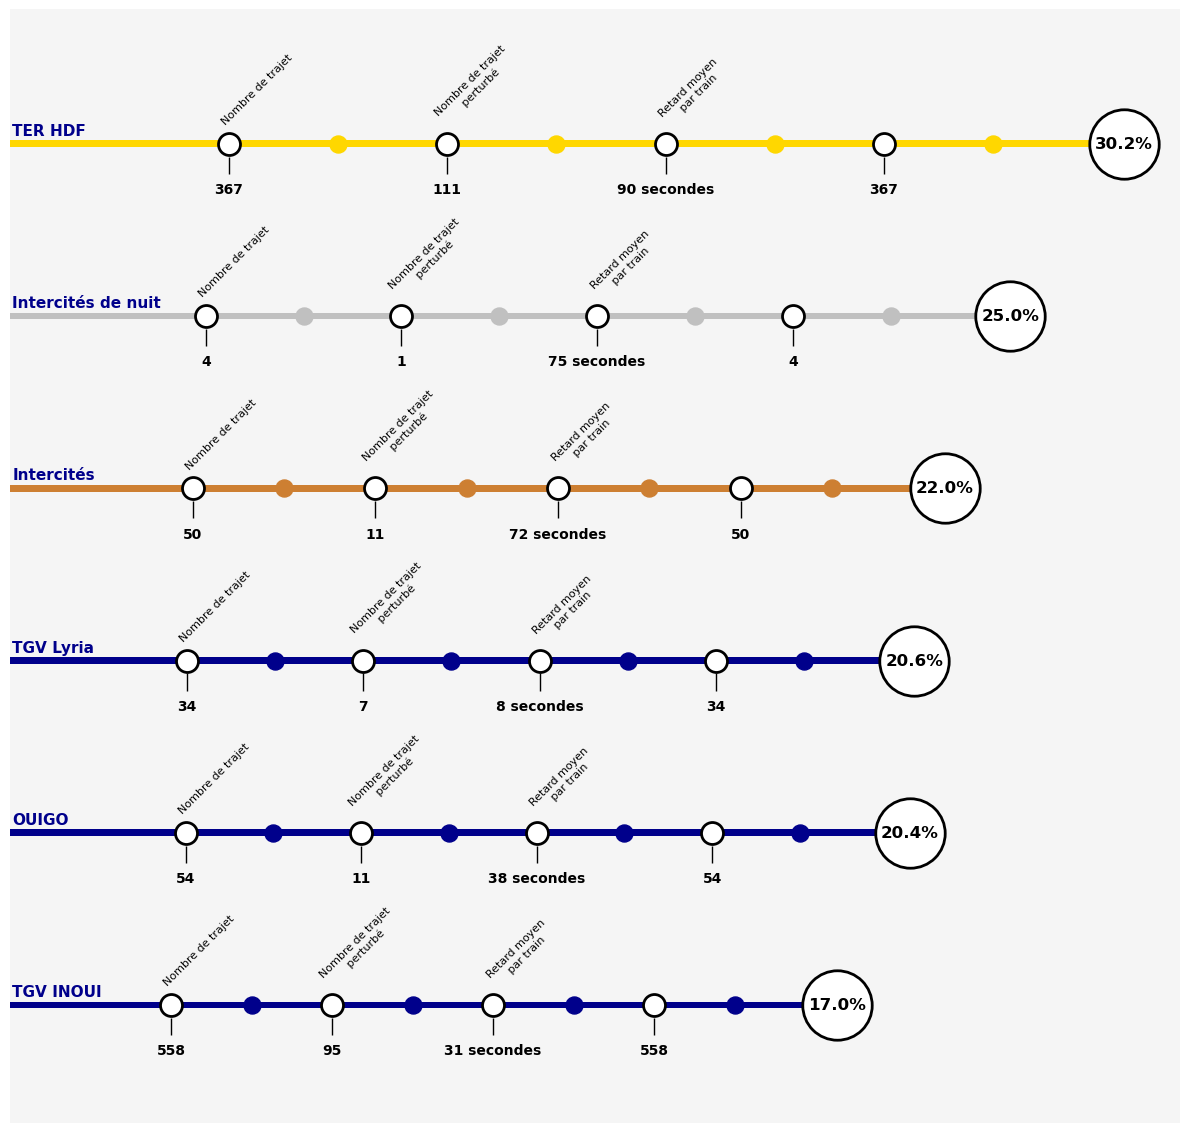

In [20]:
# Je n'ai pas encore décidé des informations à présenter, c'est pourquoi il y a des répétitions

per_disrupted_vehicle_by_network_part1 = dict(per_disrupted_vehicle_by_network[6:])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part1.items()}

keys = list(transformation.keys())
values = list(transformation.values())

colors = ['darkblue','darkblue','darkblue',"#CD7F32", "#C0C0C0", "#FFD700"]

bars = ax.barh(keys, values, color=colors, height=0.04)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        facecolors = colors[j]
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors=facecolors, s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part1.png", dpi = 300)

plt.show()

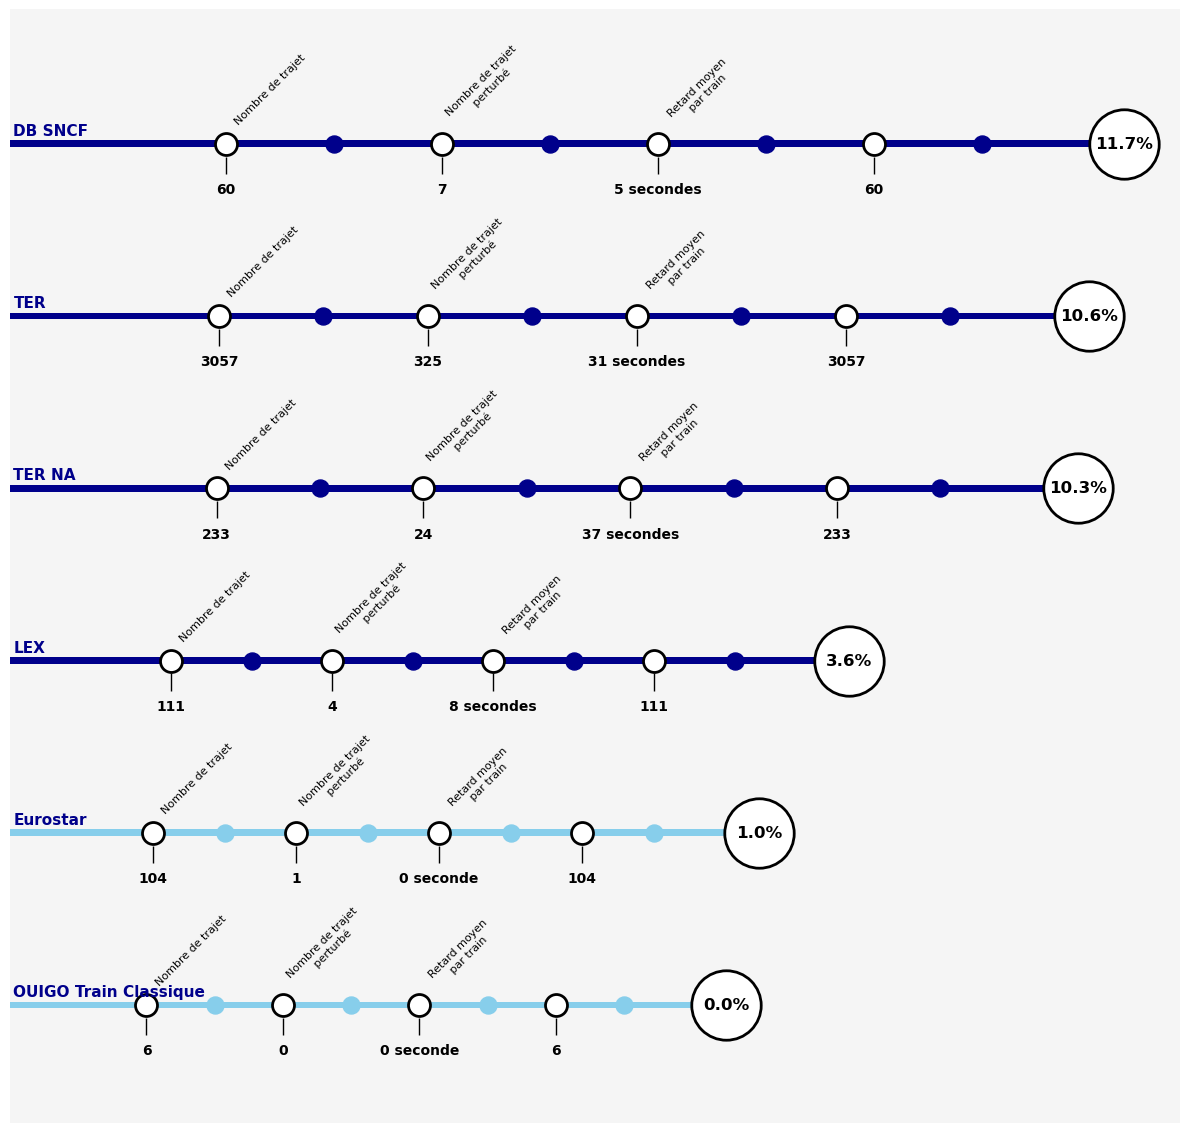

In [21]:
per_disrupted_vehicle_by_network_part2 = dict(per_disrupted_vehicle_by_network[:6])

fig, ax = plt.subplots(figsize=(12, 12))

transformation = {key: (value+20)*0.1 for key, value in per_disrupted_vehicle_by_network_part2.items()}

keys = list(transformation.keys())
values = list(transformation.values())

colors = ['skyblue', 'skyblue','darkblue','darkblue','darkblue','darkblue']

bars = ax.barh(keys, values, color=colors, height=0.04)

x_positions = [value + 0.1 for value in values]

ax.scatter(x_positions, list(transformation.keys()), facecolors='white', edgecolors='black', linewidths=2, s=2500)

intervals_white = [0.2, 0.4, 0.6, 0.8]
intervals_black = [0.3, 0.5, 0.7, 0.9]

for j, (bar, new_x) in enumerate(zip(bars, x_positions)):
    y = bar.get_y() + bar.get_height() / 2
    width = bar.get_width()
    
    # Texte pour le pourcentage à droite
    ax.text(new_x, y, f'{width/0.1 - 20:.1f}%', ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Placement des noms des réseaux au début de chaque barre.
    ax.text(0.01, y+0.075, keys[j], ha='left', va='center', fontsize=11, fontweight='bold', color='darkblue')
    
    for i, interval in enumerate(intervals_white):
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors='white', edgecolors='black', linewidths=2, s=250)
        
        line_start = y - 0.075
        line_end = y - 0.175
        ax.vlines(circle_x, line_start, line_end, colors='black', linewidth=1)
        
        # Texte sous la barre verticale
        text_y_position_below = line_end - 0.05
        current_info_value = info[i][keys[j]]
        ax.text(circle_x, text_y_position_below, f'{current_info_value}', ha='center', va='top', fontsize=10, fontweight='bold')
        
        # Texte au-dessus du cercle
        text_y_position_above = y + 0.1 
        above_text = info_name[i]
        ax.text(circle_x + 0.13, text_y_position_above, above_text, ha='center', va='bottom', fontsize=8, rotation=45)
        
    for interval in intervals_black:
        facecolors = colors[j]
        circle_x = width * interval
        ax.scatter(circle_x, y, facecolors=facecolors, s=150)

ax.set_title('', fontsize=22)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.set_facecolor('whitesmoke')
sns.despine(left=True, bottom=True, ax=ax, offset=10, trim=True)

plt.tight_layout()
ax.set_ylim(bottom=ax.get_ylim()[0] -0.25, top=ax.get_ylim()[1] +0.5)
plt.savefig("Perturbation_ligne_part2.png", dpi = 300)

plt.show()

## Routes les plus perturbées (graphique à faire)

In [22]:
vehicle_by_route = df_vehicle_merge.groupby('route_name')['vehicle_id'].count()
vehicle_by_route = vehicle_by_route[vehicle_by_route >= 10]
vehicle_by_route

route_name
(Namur) - (Charleroi) - Maubeuge    14
Alençon - Château Du Loir           12
Ambérieu - Chambery                 12
Amsterdam Centraal - Paris Nord     11
Angers St Laud - Le Mans            25
                                    ..
Tours - Le Croisic                  15
Tours - Loches                      12
Tours - Saumur - Angers - Nantes    11
Wissembourg - Neustadt              32
YVETOT - ROUEN - ELBEUF             32
Name: vehicle_id, Length: 171, dtype: int64

In [23]:
disrupted_vehicle_by_route = df_vehicle_merge[df_vehicle_merge['id_disruption'].notna()].groupby('route_name')['vehicle_id'].count()
disrupted_vehicle_by_route

route_name
(Namur) - (Charleroi) - Maubeuge              3
11. Poitiers-Tours                            1
Ambérieu - Chambery                           5
Angers St Laud - Le Mans                      4
Annecy - Paris - Gare de Lyon - Hall 1 & 2    1
                                             ..
Tours - Poitiers                              1
Tours-Vendôme-Châteaudun                      1
Tours-Voves-Chartres                          1
Valenciennes - Paris Nord                     1
Wissembourg - Neustadt                        6
Name: vehicle_id, Length: 191, dtype: int64

In [24]:
per_disrupted_vehicle_by_route = disrupted_vehicle_by_route/vehicle_by_route *100
winners = per_disrupted_vehicle_by_route.sort_values(ascending=True)[:10]
nb_train_winners = vehicle_by_route.loc[winners.index]
print("Les 10 routes les moins impactées (min 10 trajets)\n\n" + str(winners) + "\n\n\n")
print("Nombre de trajet des 10 routes les moins impactées\n\n" + str(nb_train_winners))

Les 10 routes les moins impactées (min 10 trajets)

route_name
Avignon Tgv - Avignon Centre - Carpentras            1.785714
LER                                                  2.000000
Nantes - Clisson                                     2.173913
Château-Thierry - Reims                              2.564103
Paris - Gare de Lyon - Hall 1 & 2 - Lyon Perrache    2.564103
Marseille - Aix En Provence - Manosque - Sisteron    2.898551
Rennes - St-Malo                                     2.941176
Besancon V -  Besançon Fc                            2.941176
Rouen - Dieppe                                       3.225806
L4                                                   3.260870
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 routes les moins impactées

route_name
Avignon Tgv - Avignon Centre - Carpentras            56
LER                                                  50
Nantes - Clisson                                     46
Château-Thierry - Reims                           

In [25]:
losers = per_disrupted_vehicle_by_route.sort_values(ascending=False)[:10]
nb_train_losers = vehicle_by_route.loc[losers.index]
print("Les 10 routes les plus impactées (min 10 trajets)\n\n" + str(losers) + "\n\n\n")
print("Nombre de trajet des 10 routes les plus impactées\n\n" + str(nb_train_losers))

Les 10 routes les plus impactées (min 10 trajets)

route_name
C40                                                74.418605
P42                                                65.000000
P44                                                62.500000
K40                                                52.173913
Dijon - Laroche - Auxerre                          45.454545
CAEN - LISIEUX (périurbain)                        44.444444
Ambérieu - Chambery                                41.666667
Toulouse Matabiau - Montrejeau Gourdan Polignan    33.333333
Dijon-Besançon                                     30.303030
Paris - Montparnasse - Hall 1 & 2 - Hendaye        30.000000
Name: vehicle_id, dtype: float64



Nombre de trajet des 10 routes les plus impactées

route_name
C40                                                43
P42                                                20
P44                                                24
K40                                                23
Dijon - Laroch

## Arrêts le plus impactés (Graphique N°2)

In [26]:
most_impacted_stop = df_disruption.groupby('name_stop')['vehicle_id'].count().sort_values(ascending=False)[:50]

print("Arrets les plus impactés par les perturbations : \n\n" + str(most_impacted_stop))

Arrets les plus impactés par les perturbations : 

name_stop
Lille Flandres                       62
Douai                                48
Lyon Part Dieu                       48
Strasbourg                           44
Nancy                                42
Metz                                 38
Paris - Montparnasse - Hall 1 & 2    35
Arras                                35
Toulouse Matabiau                    34
Bordeaux Saint-Jean                  34
Amiens                               29
Nantes                               28
Marseille Saint-Charles              28
Rennes                               28
Lyon Perrache                        27
Grenoble                             25
Mulhouse                             24
Paris Nord                           22
Dijon                                21
Pont-à-Mousson                       21
Chambéry - Challes-les-Eaux          21
Pagny-sur-Moselle                    20
Valence Ville                        19
Paris - Gare de Lyo

### Regroupement ville/gare tres proche

In [29]:
most_impacted_stop =  most_impacted_stop.sort_index()
most_impacted_stop_new = {}
name_to_ereased = []

for i in range(len(most_impacted_stop)):
    count_disruption_city = most_impacted_stop.iloc[i]

    for j in range(i + 1, len(most_impacted_stop)):
        if (int(stops_lon_lat['lon'].iloc[i] * 10) / 10 == int(stops_lon_lat['lon'].iloc[j] * 10) / 10) and \
           (int(stops_lon_lat['lat'].iloc[i] * 10) / 10 == int(stops_lon_lat['lat'].iloc[j] * 10) / 10):
            count_disruption_city += most_impacted_stop.iloc[j]        
            name_to_ereased.append(most_impacted_stop.index[j])
    
    most_impacted_stop_new[most_impacted_stop.index[i]] = count_disruption_city    
    
most_impacted_stop_new = pd.Series(most_impacted_stop_new, name="Total Disruptions").drop(name_to_ereased)

### Suppression de la gare la moins perturbée quand regroupement de gare proche mais pas suffisement pour former un meme point

In [32]:
name_to_erase = []

for i in range(len(most_impacted_stop_new)):
    list_stop = [(most_impacted_stop_new.index[i], most_impacted_stop_new.iloc[i])]
    for j in range(i + 1, len(most_impacted_stop_new)):
        if abs(stops_lon_lat_new['lon'].iloc[i] - stops_lon_lat_new['lon'].iloc[j]) < 0.5 and \
           abs(stops_lon_lat_new['lat'].iloc[i] - stops_lon_lat_new['lat'].iloc[j]) < 0.5:
            list_stop.append((most_impacted_stop_new.index[j], most_impacted_stop_new.iloc[j]))
    
    if len(list_stop) > 1:
        list_stop.sort(key=lambda x: x[1])
        name_to_erase.extend([idx for idx, _ in list_stop[:-1]])

name_to_erase = list(set(name_to_erase))

most_impacted_stop_new_V2 = most_impacted_stop_new.drop(name_to_erase)

In [33]:
stops_lon_lat = df_disruption[df_disruption['name_stop'].isin(most_impacted_stop_new_V2.index)].groupby('name_stop').agg({'lon': 'first', 'lat': 'first'}).reset_index()

longitudes = list(stops_lon_lat['lon'])
latitudes = list(stops_lon_lat['lat'])

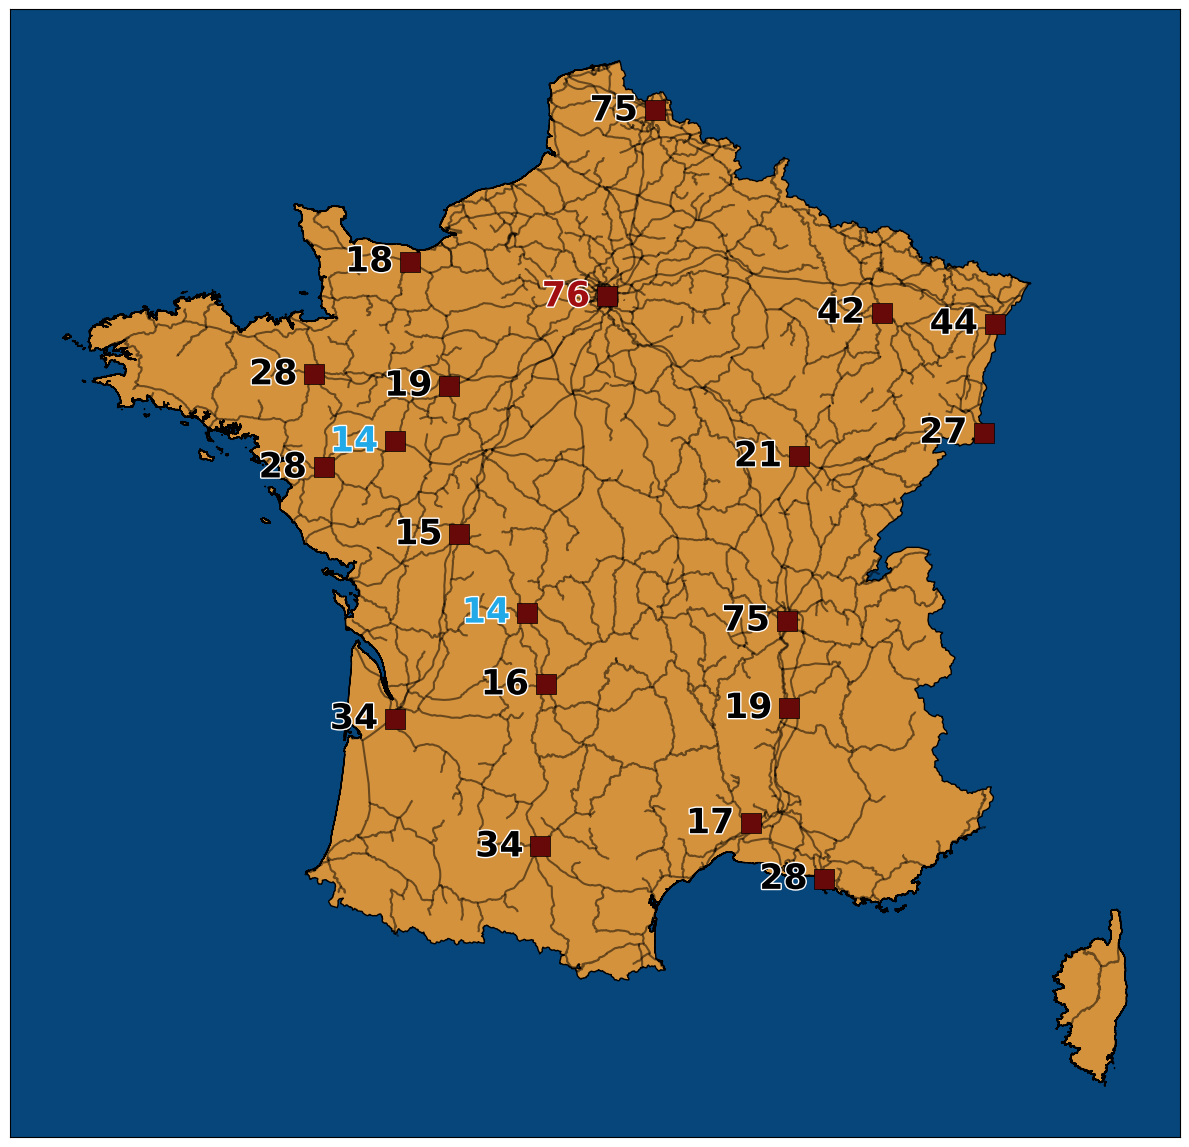

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))

reseau = gpd.read_file('formes-des-lignes-du-rfn/formes-des-lignes-du-rfn.shp')
france = gpd.read_file('data/France/FRA_adm0.shp')

ax.set_facecolor('#07467b')

france.plot(ax=ax, color='#d4923d', edgecolor='black') 
reseau.plot(ax=ax, color='black', alpha=0.5)  

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

ax.scatter(longitudes, latitudes, s=200, color='#670908', edgecolor='black', linewidth=0.5, zorder=3, alpha=1, marker='s')

for lon, lat, value in zip(longitudes, latitudes, list(most_impacted_stop_new_V2)): 
    if value >= 100:
        minuslon = 1.3
    else :
        minuslon = 0.9
    text_effect = patheffects.withStroke(linewidth=2, foreground="white")
    if value == max(most_impacted_stop_new_V2):
        ax.text(lon - minuslon, lat, str(value), verticalalignment='center', fontsize=25, color='#a10e12', fontweight='bold', path_effects=[text_effect])
    elif value == min(most_impacted_stop_new_V2):
        ax.text(lon - minuslon, lat, str(value), verticalalignment='center', fontsize=25, color='#21a9e8', fontweight='bold', path_effects=[text_effect])
    else:
        ax.text(lon - minuslon, lat, str(value), verticalalignment='center', fontsize=25, color='black', fontweight='bold', path_effects=[text_effect])

plt.tight_layout()
plt.savefig("Meteo_retard_couleur.png", dpi=300)

plt.show()

## Nombre de perturbation au fil de la journée et cause perturbation (Graphique N°3)

In [36]:
most_causes_disruption = df_disruption_unique.groupby('cause_delay')['id_disruption'].count().sort_values(ascending=True)[:100]
print("cause de perturbation les moins fréquentes de la journée : \n\n" + str(most_causes_disruption))

cause de perturbation les moins fréquentes de la journée : 

cause_delay
Dérangement d'un équipement technique ou informatique         1
Incident technique sur la voie                                1
Obstacle sur la voie                                          1
Erreur d'itinéraire                                           1
Présence d'animaux sur la voie                                1
Présence d'individus sur les voies                            1
Modification de matériel                                      1
Assistance à un voyageur                                      1
Acte de vandalisme                                            1
Choc nécessitant une vérification technique sur le train      1
Intervention des forces de l'ordre                            2
Dérangement d'une installation en gare                        3
Assistance à un voyageur malade à bord                        5
Saturation des voies en gare                                  5
Indisponibilité d'un matériel  

In [37]:
print("pourcentage d'apparaition de chacune des causes : \n\n" + str(most_causes_disruption/nb_disruption*100))

pourcentage d'apparaition de chacune des causes : 

cause_delay
Dérangement d'un équipement technique ou informatique        0.155763
Incident technique sur la voie                               0.155763
Obstacle sur la voie                                         0.155763
Erreur d'itinéraire                                          0.155763
Présence d'animaux sur la voie                               0.155763
Présence d'individus sur les voies                           0.155763
Modification de matériel                                     0.155763
Assistance à un voyageur                                     0.155763
Acte de vandalisme                                           0.155763
Choc nécessitant une vérification technique sur le train     0.155763
Intervention des forces de l'ordre                           0.311526
Dérangement d'une installation en gare                       0.467290
Assistance à un voyageur malade à bord                       0.778816
Saturation des voies en ga

In [38]:
df_disruption_unique = df_disruption.drop_duplicates(['id_disruption','vehicle_id'])

start = [t.time() for t in df_disruption_unique['disruption_start']]
end = [t.time() for t in df_disruption_unique['disruption_end']]

In [39]:
start_time = datetime(2023, 1, 1, 0, 0) 
end_time = datetime(2023, 1, 2, 0, 0)  

ten_intervals = []
current_time = start_time
while current_time < end_time:
    ten_intervals.append(current_time.time())
    current_time += timedelta(minutes=10)

In [40]:
hours_intervals_name = []
count=6

for t in range(0,len(ten_intervals)):
    if count == 6 :
        hours_intervals_name.append(str(ten_intervals[t])[:5])
        count=0
    else :
        hours_intervals_name.append('')
    count+= 1

In [41]:
disrupiton_by_ten = []

for time in ten_intervals:
    nb_disruption = 0
    for i in range(len(start)):
        if time > start[i] and time < end[i]:
            nb_disruption += 1 
    disrupiton_by_ten.append(nb_disruption)

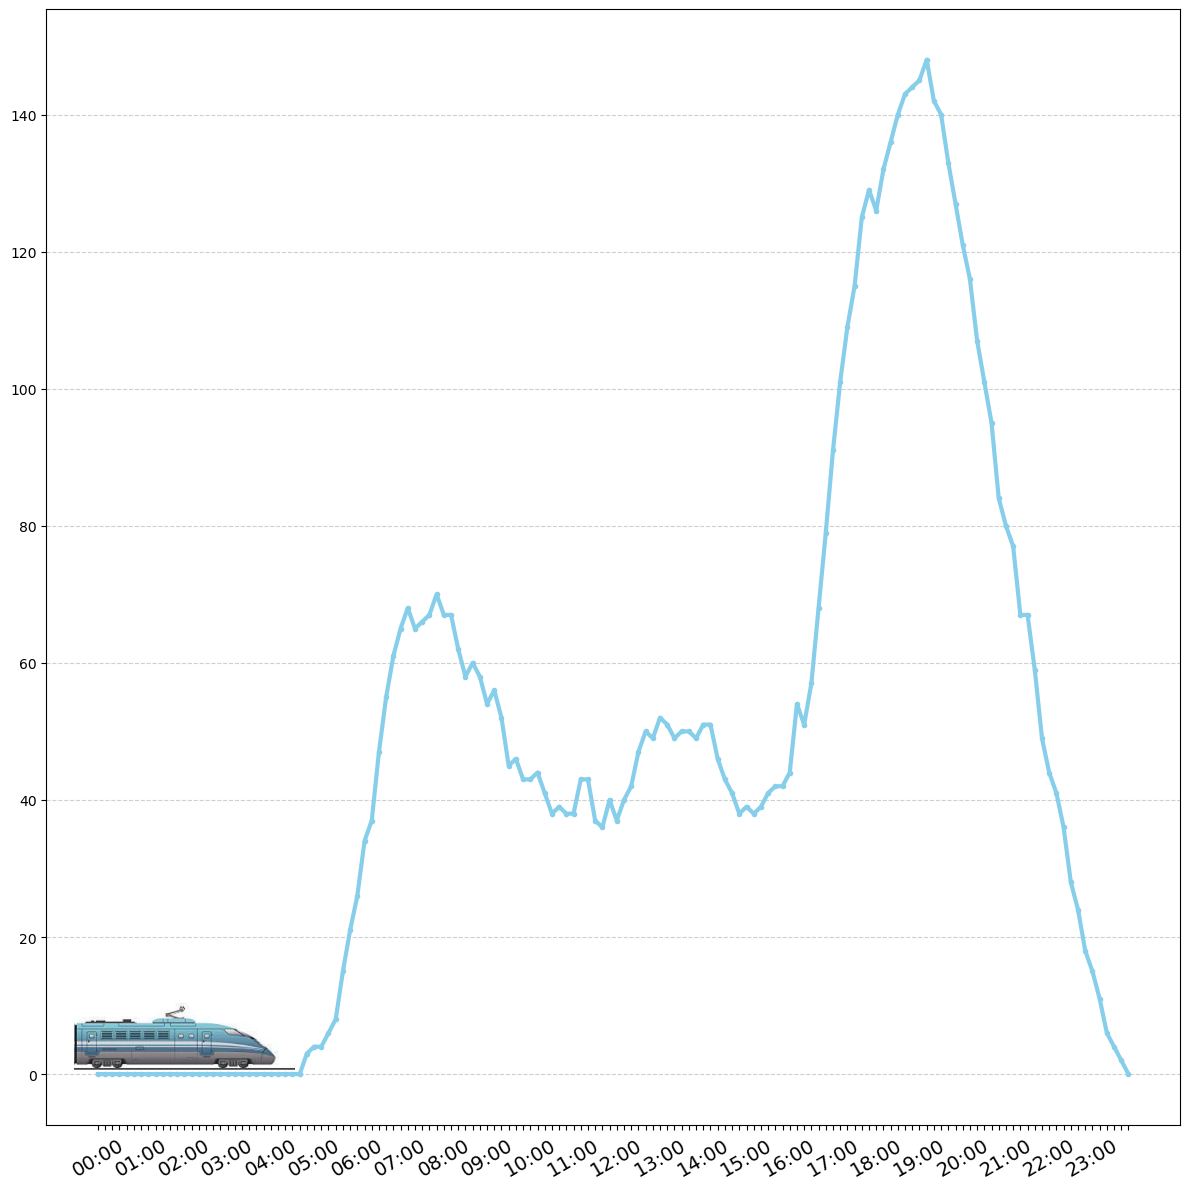

In [42]:
plt.figure(figsize=(12, 12))
plt.plot(range(len(disrupiton_by_ten)), disrupiton_by_ten, c='skyblue', lw=3, marker='o', markersize=3)

plt.xticks(range(len(disrupiton_by_ten)), hours_intervals_name, rotation=30, fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6, axis='y')
plt.gca().set_facecolor('white')
plt.tight_layout()

img = mpimg.imread('Data/Train.png')
imagebox = OffsetImage(img, zoom=0.4)
ab = AnnotationBbox(imagebox, (12, 6), frameon=False)
plt.gca().add_artist(ab)

plt.savefig("Perturbation_journée.png", dpi=300)

plt.show()

In [2]:
# Metrre en avant la premiere perturbation de la journée avec les infos deja collecté 
# Mettre à certaine horraire des causes de perturbation
# Remplire l'aire sous la courbe avec les pourcentages d'apparitiond e chacune des causes